In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage import filters
from skimage import morphology
import math
from skimage import measure
import time
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#Wczytywanie obrazków, image w 2 wariantach - czarno białym i kolorowym
dt=[('0' if x<10 else '')+str(x) for x in range(1, 15)]
dy=[[y+'_'+x for y in dt] for x in ['dr', 'h', 'g']]
z=[]
for x in dy:
    z=z+x
print(z)

flag=cv2.IMREAD_GRAYSCALE
#flag=cv2.IMREAD_COLOR
Manuals = [cv2.imread(f"manual1/{x}.tif", flag) for x in z]
Masks= [cv2.imread(f"mask/{x}_mask.tif", flag) for x in z]
Images= [cv2.imread(f"images/{x}.jpg", flag) for x in z]

zupaImagez=[cv2.imread(f"images/{x}.jpg", cv2.IMREAD_COLOR) for x in z]

Creation=[list(w) for w in zip(Manuals, Masks, Images, zupaImagez)]

['01_dr', '02_dr', '03_dr', '04_dr', '05_dr', '06_dr', '07_dr', '08_dr', '09_dr', '10_dr', '11_dr', '12_dr', '13_dr', '14_dr', '01_h', '02_h', '03_h', '04_h', '05_h', '06_h', '07_h', '08_h', '09_h', '10_h', '11_h', '12_h', '13_h', '14_h', '01_g', '02_g', '03_g', '04_g', '05_g', '06_g', '07_g', '08_g', '09_g', '10_g', '11_g', '12_g', '13_g', '14_g']


In [34]:
#Normalizacja - Otrzymane wyniki będą nieznormalizowane przy pominięciu tej komórki
#W pokazywanych w sprawozdaniu rezultatach nie zaszła normalizacja
blurk=np.asarray([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9
blurk2=np.asarray([[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]])/256

res=[]
for i, x in enumerate(Creation[:20]):
    sv=x[3]
    
    #####  NORMALIZACJA  #####
    mx, mn=max(sv[sv>-1]), min(sv[sv>-1])
    sv=(sv-mn)/(mx-mn)
    sv[:,:,0]=np.multiply(sv[:,:,0], x[1]/255)
    sv[:,:,1]=np.multiply(sv[:,:,1], x[1]/255)
    sv[:,:,2]=np.multiply(sv[:,:,2], x[1]/255)
    sv=np.asarray(sv*255, dtype='uint8')
    
    #####  DENOISING  #####
    raka=sv
    raka=np.asarray(raka, dtype='uint8')
    raka=cv2.fastNlMeansDenoising(raka)
    
    #####  BLURRING  #####
    dt=raka
    dt[:,:,0]=np.absolute(signal.convolve2d(raka[:,:,0], blurk2, mode='same'))
    dt[:,:,1]=np.absolute(signal.convolve2d(raka[:,:,1], blurk2, mode='same'))
    dt[:,:,2]=np.absolute(signal.convolve2d(raka[:,:,2], blurk2, mode='same'))
    dt[dt>255]=255
    for i in range(10): 
        dt[:,:,0]=np.absolute(signal.convolve2d(dt[:,:,0], blurk2, mode='same'))
        dt[:,:,1]=np.absolute(signal.convolve2d(dt[:,:,1], blurk2, mode='same'))
        dt[:,:,2]=np.absolute(signal.convolve2d(dt[:,:,2], blurk2, mode='same'))
        dt[dt>255]=255
    
    #Rezultat - używany w następnych fazach algorytmu
    Creation[i][3]=dt

KeyboardInterrupt: 

In [4]:
#Dodanie paddingu do obrazka
def pad(img, con=3):
    if (len(img.shape)==2):
        dt=np.zeros((img.shape[0]+2*con, img.shape[1]+2*con), dtype='uint8')
        dt[con:dt.shape[0]-con,con:dt.shape[1]-con]=img
    else:
        dt=np.zeros((img.shape[0]+2*con, img.shape[1]+2*con, img.shape[2]), dtype='uint8')
        dt[con:dt.shape[0]-con,con:dt.shape[1]-con]=img
    
    return dt

#Informacje o części obrazka
def getItem(img, x, y, mask, con=3, img2=None):
    if (img2 is None):
        mcen=measure.moments_central(img[x-con:x+con,y-con:y+con])
        vz=[img[x-con:x+con,y-con:y+con].var()]
    else:
        mcen=measure.moments_central(img2[x-con:x+con,y-con:y+con])
        vz=[img2[x-con:x+con,y-con:y+con,z].var() for z in range(3)]
    col=[img[x,y]]
    maske=[np.all(mask[x-con:x+con,y-con:y+con])]
    lees=np.concatenate((vz, col, np.reshape(mcen, mcen.shape[0]*mcen.shape[1]*mcen.shape[2]), maske))
    return lees

#Wzięcie odpowiedzi dla punktów wymienionych w tuplu
def getImagoRandomoRes(resimg, tupls):
    res=[]
    for x in tupls:
        res.append(resimg[x[0], x[1]])
    return np.asarray(res)

#Wybór losowych danych, szerzej opisany w sprawozdaniu; 0 - manual, 1 - maska, 2 - oryginał
def randomizer(set_img, Z=40001, signify=0):
    Cnt=5
    img2=pad(set_img[2], Cnt)
    img3=pad(set_img[3], Cnt)
    maska=pad(set_img[1], Cnt)
    dissolve=[]
    tuplez=[]
    setall=set()
    
    for i in range(Z):
        while (True):
            rn=np.random.randint(0, set_img[0].shape[0]*set_img[0].shape[1])
            rny=rn%set_img[1].shape[1]
            rnx=rn//set_img[1].shape[1]
            
            if (signify==0 and 
                set_img[1][rnx,rny]!=0 and
                (set_img[0][rnx,rny]!=0 or
                 np.random.randint(0, 4)%4==0) and
               {(rnx, rny)} not in setall):
                break
            elif (signify==1 and 
                set_img[1][rnx,rny]!=0 and
               {(rnx, rny)} not in setall):
                break
        dissolve.append(getItem(img2, rnx+Cnt, rny+Cnt, maska, Cnt, img3))
        setall|={(rnx, rny)}
        tuplez.append((rnx, rny))
        #print(rnx, rny, set_img[0][rnx,rny])
    return np.asarray(dissolve), tuplez

#Preprocessing danych
def preproc(data):
    dv=sklearn.preprocessing.normalize(data)
    return dv

#Ewaluacja heurystyki
def evaluator(im1, im2):
    dicc={}
    dicc["1st B"]=len(im1[im1==0])
    dicc["1st W"]=len(im1[im1!=0])
    dicc["2nd B"]=len(im2[im2==0])
    dicc["2nd W"]=len(im2[im2!=0])
    
    dicc["tp"]=len(im2[(im2==im1) & (im2!=0)])
    dicc["tn"]=len(im2[(im2==im1) & (im2==0)])
    dicc["fp"]=len(im2[(im2!=im1) & (im2!=0)])
    dicc["fn"]=len(im2[(im2!=im1) & (im2==0)])
    _=[print(x, dicc[x]) for x in ["tp", "tn", "fp", "fn"]]
    if (dicc["fn"]==0):
        dicc["fn"]=1
    
    dicc["acc"]=(dicc["tp"]+dicc["tn"])/(dicc["tp"]+dicc["tn"]+dicc["fp"]+dicc["fn"])
    dicc["prec"]=dicc["tp"]/(dicc["tp"]+dicc["fp"])
    dicc["rec"]=dicc["tp"]/(dicc["tp"]+dicc["fn"])
    
    return dicc

In [7]:
t1=time.time()
#Wyznaczenie trainseta i wyniku tego seta

x1=[]
y1=[]
#Wyznaczenie trainseta i wyniku tego seta
for i in [0, 9, 15]:
    xv, locsv=randomizer(Creation[i], signify=0)
    yv=getImagoRandomoRes(Creation[i][0], locsv)
    x1=x1+list(xv)
    y1=y1+list(yv)
    print(i)
x1=np.asarray(x1)
y1=np.asarray(y1)
    
##Normalizacja trainseta, uwypuklenie kluczowych cech
xp1=preproc(x1)

#Stworzenie klasyfikatora z liczbą sąsaidów równą 5 - empirycznie jest to w miarę optymalna liczba
ncl=KNeighborsClassifier(n_neighbors=5)
ncl.fit(xp1, y1)
t2=time.time()
print(t2-t1)

0
9
15
26.9864559173584


In [8]:
#Estymacja parametrów dla zrandomizowanych podzbiorów poszczególnych obrazków
ln, sgeom=20, 0
allres=[]
for i in range(0, ln):
    t1=time.time()
    
    xt, locst=randomizer(Creation[i], signify=1)
    yt=getImagoRandomoRes(Creation[i][0], locst)
    xpt=preproc(xt)
    ypt=ncl.predict(xpt)
    print()
    print(f"Obraz {i+1}:")
    dct=evaluator(yt, ypt)
    print(f"acc:{dct['acc']}, prec:{dct['prec']}, rec:{dct['rec']}, geom:{math.sqrt(dct['prec']*dct['rec'])}")
    
    t2=time.time()
    print(t2-t1)
    print()
    sgeom=sgeom+math.sqrt(dct['prec']*dct['rec'])
    dct['sgeom']=math.sqrt(dct['prec']*dct['rec'])
    dct['title']=f'kNN-{z[i]}'
    allres.append(dct)
print(f"result: {sgeom/ln}")


Obraz 1:
tp 1281
tn 36302
fp 1372
fn 1046
acc:0.9395515112122197, prec:0.48284960422163586, rec:0.5504941985388913, geom:0.515563677823419
79.49702501296997


Obraz 2:
tp 1502
tn 35273
fp 1659
fn 1567
acc:0.9193520161995951, prec:0.4751660866814299, rec:0.4894102313457152, geom:0.4822355694164386
81.36152386665344


Obraz 3:
tp 767
tn 36344
fp 765
fn 2125
acc:0.9277518062048449, prec:0.5006527415143603, rec:0.2652143845089903, geom:0.3643903246430532
98.48530340194702


Obraz 4:
tp 1133
tn 35736
fp 1498
fn 1634
acc:0.9217019574510638, prec:0.4306347396427214, rec:0.40946873870618, geom:0.41991840122167706
88.4410183429718


Obraz 5:
tp 2241
tn 31646
fp 5494
fn 620
acc:0.8471538211544711, prec:0.28972204266321916, rec:0.7832925550506816, geom:0.47637917571213745
89.60759091377258


Obraz 6:
tp 2494
tn 29520
fp 6941
fn 1046
acc:0.8003299917502062, prec:0.2643349231584526, rec:0.7045197740112994, geom:0.4315427908410558
84.92915225028992


Obraz 7:
tp 1867
tn 34594
fp 1840
fn 1700
acc:0.

In [25]:
c0=1000
c1=600
Im=1
dissolve=[]
Cnt=5

t1=time.time()
img2=pad(Creation[Im][2], Cnt)
img3=pad(Creation[Im][3], Cnt)
maska=pad(Creation[Im][1], Cnt)
for i in range(c0, c0+c1):
    for j in range(c0, c0+c1):
        dissolve.append(getItem(img2, i+Cnt, j+Cnt, maska, Cnt, img3))

t2=time.time()
print(t2-t1)

70.29156875610352


In [26]:
t1=time.time()
dt=np.zeros((c1, c1), dtype='float64')
xv=preproc(dissolve)
ypt=ncl.predict(np.asarray(xv))

ij=0
for i in range(c0, c0+c1):
    for j in range(c0, c0+c1):
        dt[i-c0,j-c0]=ypt[ij]
        ij+=1

t2=time.time()
print(t2-t1)

201.76561784744263


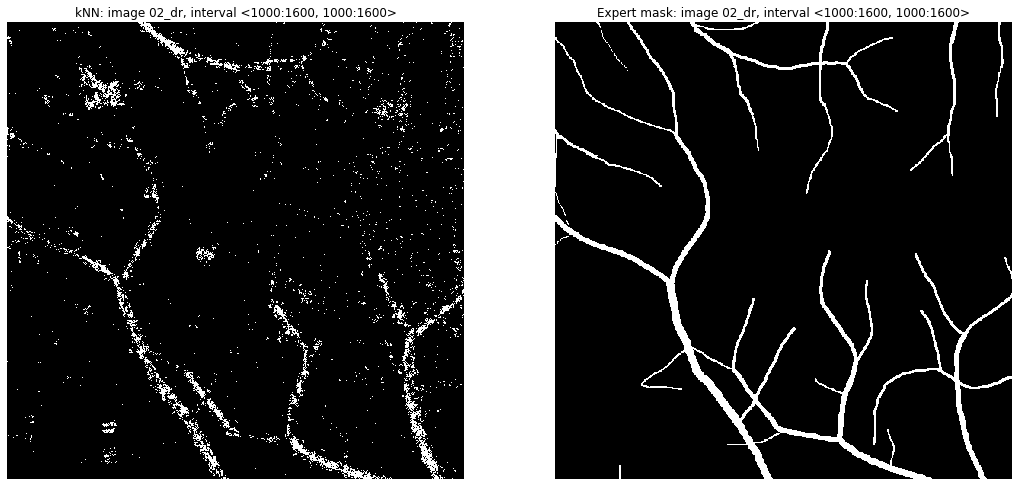

In [27]:
#Obraz efektów pracy klasyfikatora
fig, ax=plt.subplots(1, 2, figsize=(18,18))
ax[1].imshow(Creation[Im][0][c0:c0+c1,c0:c0+c1], cmap='gray')
ax[0].imshow(dt, cmap='gray')
ax[0].set_title(f"kNN: image {z[Im]}, interval <{c0}:{c0+c1}, {c0}:{c0+c1}>")
ax[1].set_title(f"Expert mask: image {z[Im]}, interval <{c0}:{c0+c1}, {c0}:{c0+c1}>")
ax[1].set_axis_off()
ax[0].set_axis_off()
plt.show()

In [9]:
#Dane częściowe klasyfikatora
allez={}
for x in allres:
    print(f"{x['title']} & {x['tp']} & {x['tn']} & {x['fn']} & {x['fp']} & {x['acc']:.4f} & {x['prec']:.4f} & {x['rec']:.4f} & {x['sgeom']:.4f} \\\\ \hline")
    for y in x:
          if y not in allez:
              allez[y]=x[y]
          else:
              allez[y]+=x[y]

kNN-01_dr & 1281 & 36302 & 1046 & 1372 & 0.9396 & 0.4828 & 0.5505 & 0.5156 \\ \hline
kNN-02_dr & 1502 & 35273 & 1567 & 1659 & 0.9194 & 0.4752 & 0.4894 & 0.4822 \\ \hline
kNN-03_dr & 767 & 36344 & 2125 & 765 & 0.9278 & 0.5007 & 0.2652 & 0.3644 \\ \hline
kNN-04_dr & 1133 & 35736 & 1634 & 1498 & 0.9217 & 0.4306 & 0.4095 & 0.4199 \\ \hline
kNN-05_dr & 2241 & 31646 & 620 & 5494 & 0.8472 & 0.2897 & 0.7833 & 0.4764 \\ \hline
kNN-06_dr & 2494 & 29520 & 1046 & 6941 & 0.8003 & 0.2643 & 0.7045 & 0.4315 \\ \hline
kNN-07_dr & 1867 & 34594 & 1700 & 1840 & 0.9115 & 0.5036 & 0.5234 & 0.5134 \\ \hline
kNN-08_dr & 924 & 35613 & 2679 & 785 & 0.9134 & 0.5407 & 0.2565 & 0.3724 \\ \hline
kNN-09_dr & 333 & 36439 & 2884 & 345 & 0.9193 & 0.4912 & 0.1035 & 0.2255 \\ \hline
kNN-10_dr & 2498 & 33478 & 1708 & 2317 & 0.8994 & 0.5188 & 0.5939 & 0.5551 \\ \hline
kNN-11_dr & 2610 & 33391 & 1365 & 2635 & 0.9000 & 0.4976 & 0.6566 & 0.5716 \\ \hline
kNN-12_dr & 558 & 36266 & 2655 & 522 & 0.9206 & 0.5167 & 0.1737 & 0.2995

In [10]:
#Dane całościowe klasyfikatora
for x in allez:
    if x in ['prec', 'acc', 'rec']:
        print(f"{allez[x]/len(allres):.4f} &", end=' ')
    elif x=='sgeom':
        print(f"{allez[x]/len(allres):.4f}")

0.8784 & 0.4857 & 0.4997 & 0.4635
